In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

In [2]:
# Custom callback to stop training when accuracy and val_accuracy reach 98%
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if accuracy is not None and val_accuracy is not None:
            if accuracy >= 0.98 and val_accuracy >= 0.98:
                print("\nReached 98% accuracy and validation accuracy, stopping training.")
                self.model.stop_training = True

In [3]:
# Path to dataset
dataset_path = 'Gigi Tampak Depan V2'

In [4]:
# Image dimensions
img_height, img_width = 224, 224
batch_size = 32

In [5]:
# Prepare the dataset with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

Found 3917 images belonging to 5 classes.
Found 976 images belonging to 5 classes.


In [6]:
# Load the ResNet50V2 model pre-trained on ImageNet, excluding the top layers
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [7]:
# Freeze the layers of ResNet50V2
base_model.trainable = False

In [8]:
# Add custom layers on top of ResNet50V2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
prediction = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=prediction)

In [9]:
# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [10]:
# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
# Define callbacks
checkpoint = ModelCheckpoint("Resnet50V2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
custom_callback = CustomCallback()

callbacks = [checkpoint, early_stopping, reduce_lr, custom_callback]

In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks
)

Epoch 1/50
123/123 [==============================] - ETA: 0s - loss: 0.8805 - accuracy: 0.6638
Epoch 1: val_accuracy improved from -inf to 0.74693, saving model to Resnet50V2.h5
123/123 [==============================] - 717s 6s/step - loss: 0.8805 - accuracy: 0.6638 - val_loss: 0.6151 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 2/50
123/123 [==============================] - ETA: 0s - loss: 0.6237 - accuracy: 0.7521
Epoch 2: val_accuracy improved from 0.74693 to 0.76537, saving model to Resnet50V2.h5
123/123 [==============================] - 589s 5s/step - loss: 0.6237 - accuracy: 0.7521 - val_loss: 0.5958 - val_accuracy: 0.7654 - lr: 0.0010
Epoch 3/50
123/123 [==============================] - ETA: 0s - loss: 0.5717 - accuracy: 0.7718
Epoch 3: val_accuracy improved from 0.76537 to 0.81148, saving model to Resnet50V2.h5
123/123 [==============================] - 547s 4s/step - loss: 0.5717 - accuracy: 0.7718 - val_loss: 0.4881 - val_accuracy: 0.8115 - lr: 0.0010
Epoch 4/50
123/123 [==

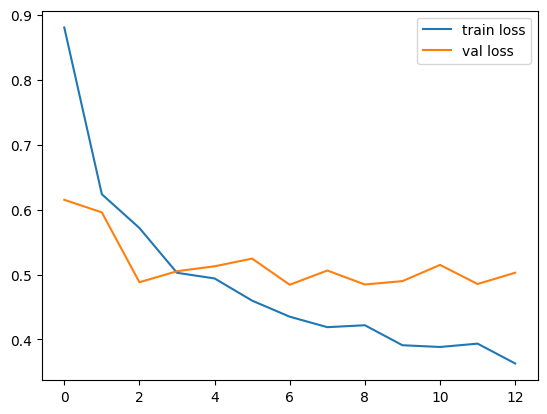

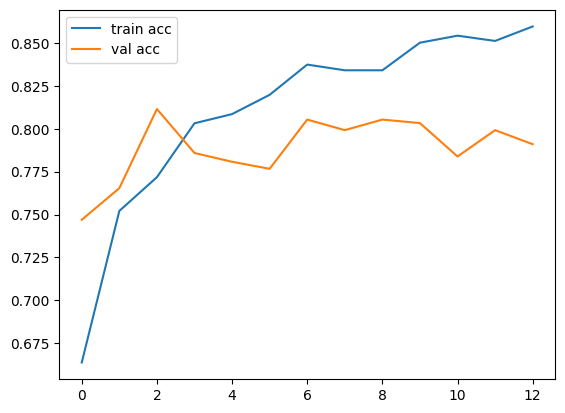

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
# Plot the Loss and Accuracy
# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [15]:
# Fine-tuning: Unfreeze some layers of the base model and re-train
for layer in base_model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

In [16]:
# Re-compile the model after unfreezing
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [17]:
# Define callbacks
checkpoint = ModelCheckpoint("Resnet50V2_fine_tuning.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
custom_callback = CustomCallback()

callbacks = [checkpoint, early_stopping, reduce_lr, custom_callback]

In [18]:
# Continue training
history_fine = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks
)

Epoch 1/50
123/123 [==============================] - ETA: 0s - loss: 0.9021 - accuracy: 0.6319
Epoch 1: val_accuracy improved from -inf to 0.47951, saving model to Resnet50V2_fine_tuning.h5
123/123 [==============================] - 925s 7s/step - loss: 0.9021 - accuracy: 0.6319 - val_loss: 2.6643 - val_accuracy: 0.4795 - lr: 0.0010
Epoch 2/50
123/123 [==============================] - ETA: 0s - loss: 0.6736 - accuracy: 0.7256
Epoch 2: val_accuracy did not improve from 0.47951
123/123 [==============================] - 722s 6s/step - loss: 0.6736 - accuracy: 0.7256 - val_loss: 1.8492 - val_accuracy: 0.4672 - lr: 0.0010
Epoch 3/50
123/123 [==============================] - ETA: 0s - loss: 0.6168 - accuracy: 0.7600
Epoch 3: val_accuracy did not improve from 0.47951
123/123 [==============================] - 676s 5s/step - loss: 0.6168 - accuracy: 0.7600 - val_loss: 2.3071 - val_accuracy: 0.4088 - lr: 0.0010
Epoch 4/50
123/123 [==============================] - ETA: 0s - loss: 0.5359 - a